## Gage Location workbook

gage data api = https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-07377782/basin
query gages https://waterservices.usgs.gov/nwis/iv/?sites=07377782&parameterCd=00060&period=P7D&siteStatus=all&format=json

gage location https://labs.waterdata.usgs.gov/api/observations/collections/monitoring-locations/items/USGS-07377782?f=json

flow line https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-07377782/navigation/UM/flowlines?distance=322

In [1]:
import sys
import os
import pathlib as pl
sys.path.append('..')
home = pl.Path(os.getcwd())

In [2]:
from src.core import *
from src.modules.curve_number.utils_CN import *

## Get stream gages within HUC basin

In [3]:
#user defined
huc12 = '030902061500'
if not os.path.exists(home/'Outputs'/huc12):
    os.makedirs(home/'Outputs'/huc12)
#write to txt file for later notebooks
with open(home/'Inputs'/'huc12.txt','w') as tfile:
    tfile.write(huc12)

### check for gage within huc12

In [4]:
hucs_gdf = get_huc_12_gdf_from_bigger_huc(huc12)
bounds = get_huc_12_bounds(huc12)

obtaining huc12 basin information
obtaining huc12 basin information


In [5]:
gage_gdf = gdf_of_local_usgs_gages(bounds)

### check for gage within huc10 or huc8 if not within huc12

In [6]:
if gage_gdf.empty is False:
    stream_gages = gage_gdf.loc[gage_gdf['gage_type']=='00060']
    huc = huc12
else:
    ### search for larger huc area (huc10 ) to find nearby gage
    hucs_gdf = get_huc_12_gdf_from_bigger_huc(huc12[:10])
    bigger_huc_bounds = np.array2string(hucs_gdf.total_bounds, precision=6, separator=',',
                          suppress_small=True)[1:-1].replace(" ", "")
    gage_gdf = gdf_of_local_usgs_gages(bigger_huc_bounds)
    if gage_gdf.empty is False:
        stream_gages = gage_gdf.loc[gage_gdf['gage_type']=='00060']
        huc = huc12[:10]
    else:
        ### search for larger huc area (huc8) to find nearby gage
        hucs_gdf = get_huc_12_gdf_from_bigger_huc(huc12[:8])
        bigger_huc_bounds = np.array2string(hucs_gdf.total_bounds, precision=6, separator=',',
                              suppress_small=True)[1:-1].replace(" ", "")
        gage_gdf = gdf_of_local_usgs_gages(bigger_huc_bounds)
        if gage_gdf.empty is False:
            stream_gages = gage_gdf.loc[gage_gdf['gage_type']=='00060']
            huc = huc12[:8]
        else:
            print('NO GAGES within HUC8!!!')

### Plot results for visuals and pertinent gage table information

In [7]:
stream_gages[['gage_number','name','sourceInfo_siteName']]

,gage_number,name,sourceInfo_siteName
0,02287497,USGS:02287497:00060:00000,N.W. WELLFIELD CANAL NR DADE BROWARD LEVEE NR ...
1,02289500,USGS:02289500:00060:00000,"TAMIAMI CANAL NEAR CORAL GABLES, FL"
2,022907647,USGS:022907647:00060:00000,LEVEE 31 NORTH EXTENSION 1 MILE NR WEST MIAMI FL
3,02290765,USGS:02290765:00060:00000,LEVEE 31 NORTH EXTENSION AT 3 MILE NR WEST MIA...
4,02290766,USGS:02290766:00060:00000,LEVEE 31 NORTH EXTENSION AT 4 MILE NR WEST MIA...
5,02290767,USGS:02290767:00060:00000,LEVEE 31 NORTH EXTENSION AT 5 MILE NR WEST MIA...
6,254157080213800,USGS:254157080213800:00060:00000,"SNAPPER CREEK NO.5 ABV WATER PIPE NR S. MIAMI, FL"


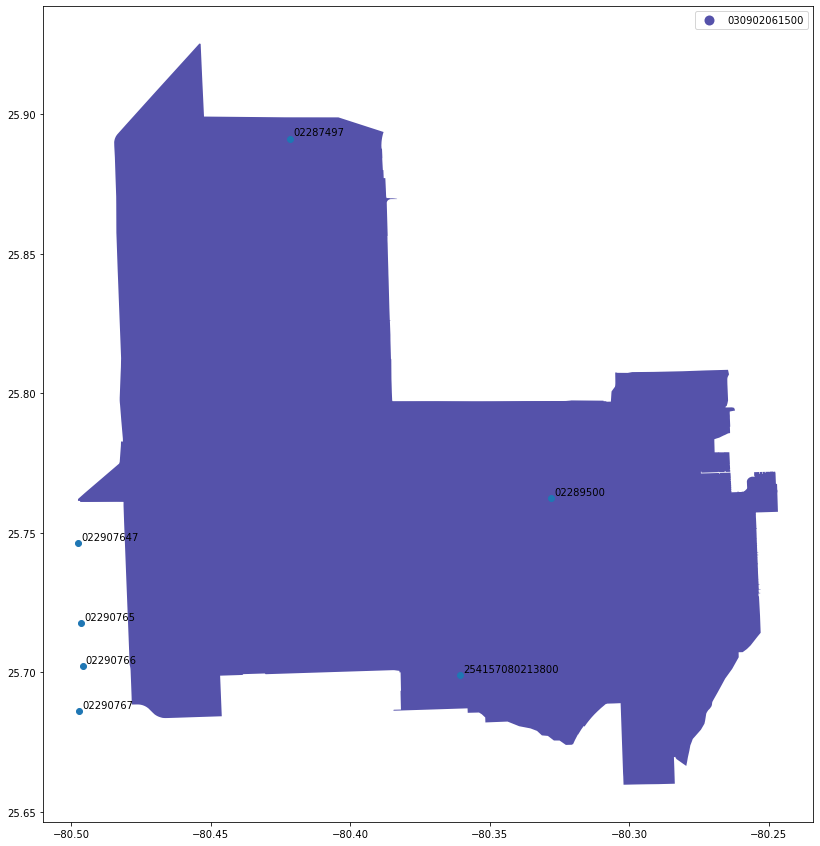

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
hucs_gdf.plot(ax=ax, alpha=0.7, cmap="plasma",cax=f'huc{len(huc)}',column=f'huc{len(huc)}',legend=True)
stream_gages.plot(ax=ax)
for x, y, label in zip(stream_gages.geometry.x, stream_gages.geometry.y, stream_gages.gage_number):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

## Get information for selected gage

In [16]:
#user selected
site = '02289500'
#write gage # to txt file for later notebooks
with open(home/'Inputs'/'stream_gage.txt','w') as tfile:
    tfile.write(site)

In [17]:
#standard variables
gage_type = '00060'
feature = 'basin'
flow = 'navigation/UM/flowlines'
sr = 4269 #nad83
inputs_dir = home/'Inputs'
outputs_dir = home/'Outputs'

In [25]:
def usgs_api_associated_gage_geometry(feature:str,site:str) -> dict:
    '''
    queries the nld api server to gather feature data
    '''
    url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-'+site+'/'+feature
    parameters = {'f':'json'}
    r = requests.get(url,params=parameters)
    try:
        response = json.loads(r.content)
    except:
        response = {'features':None}
    return response

In [34]:
gage_loc = usgs_api_gage_to_df(site,sr)
basin_features = usgs_api_associated_gage_geometry(feature,site)['features']
if basin_features:
    basin_df = json_to_df(basin_features)
    basin_gdf = df_to_gdf(basin_df,'geometry',sr)
else:
    #use basin as drainage area
    basin_gdf = hucs_gdf

### Plot results for visuals and drainage area calc

In [35]:
area_gdf = basin_gdf.to_crs(epsg=5070)
area_gdf['area_sq_mi'] = area_gdf.area*(0.000386102/1000)

In [36]:
area_gdf

,geometry,OBJECTID,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,areaacres,areasqkm,...,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,shape_Length,shape_Area,referencegnis_ids,area_sq_mi
0,"POLYGON ((1564941.846 447824.700, 1564963.632 ...",100464,{B5856E14-FE3D-4668-B63A-FA238950B9C9},{5CAC4E8B-7348-4A7F-A14E-0873518038B5},None,None,None,1428994306000,97176.39,393.26,...,Tamiami Canal,D,"GC,TF,UA",030902061701,0,0,132830.377618,4.869745e+08,None,151.838132


<AxesSubplot:>

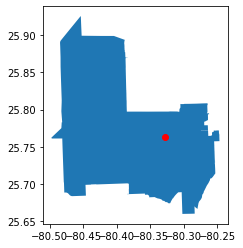

In [37]:
base = basin_gdf.plot()
gage_loc.plot(ax=base,color='red')

In [38]:
#export to geojson for later processing
hucs_gdf.to_file(outputs_dir/huc12/'{0}_{1}.geojson'.format('huc',huc12))
basin_gdf.to_file(outputs_dir/huc12/'{0}_{1}.geojson'.format('basin',site))
gage_loc.to_file(outputs_dir/huc12/'{0}_{1}.geojson'.format('gage',site))

## Get list of nearest rain gages within stream gage drainage basin

In [39]:
#get bounding box of basin
bounds = bbox_gdf(hucs_gdf)

In [40]:
search = 10
sr = basin_gdf.crs.to_epsg()
rain_gage_gdf = gdf_of_local_precip_gages(bounds,sr,search)

Found gages nearby


### check for gage within a search distance if not within huc12

In [41]:
#search distance
distancez_increment = 500 #meters
while rain_gage_gdf.empty is True:
    search+=distancez_increment
    rain_gage_gdf = gdf_of_local_precip_gages(bounds,sr,search)

### Plot results for visuals and pertinent gage table information

In [42]:
rain_gage_gdf[['STATION_ID','STATION_NAME','DATA_BEGIN_DATE','DATA_END_DATE']]

,STATION_ID,STATION_NAME,DATA_BEGIN_DATE,DATA_END_DATE
0,GHCND:USC00084518,"KENDALL 2 E, FL US",1942-01-01,1974-10-31
1,GHCND:US1FLMD0042,"SOUTH MIAMI 0.9 SSE, FL US",1998-06-17,2023-02-05
2,GHCND:US1FLMD0030,"SOUTH MIAMI 0.5 N, FL US",2011-01-01,2023-02-12
3,GHCND:USW00012859,"MIAMI WEATHER SERVICE OFFICE CITY, FL US",1948-07-01,2002-12-31
4,GHCND:US1FLMD0029,"CORAL GABLES 1.8 NNW, FL US",2011-09-21,2012-08-12
5,GHCND:US1FLMD0100,"CORAL TERRACE 1.3 SSE, FL US",2020-04-19,2022-09-28
6,GHCND:US1FLMD0095,"CORAL GABLES 4.1 NNW, FL US",2019-12-22,2021-04-20
7,GHCND:USC00083909,"HIALEAH, FL US",1940-06-29,2023-03-12
8,GHCND:USW00012882,"MIAMI OPA LOCKA AIRPORT, FL US",1998-05-21,2023-03-12
9,GHCND:USW00012852,"MIAMI MCAS, FL US",1945-03-01,1958-07-31


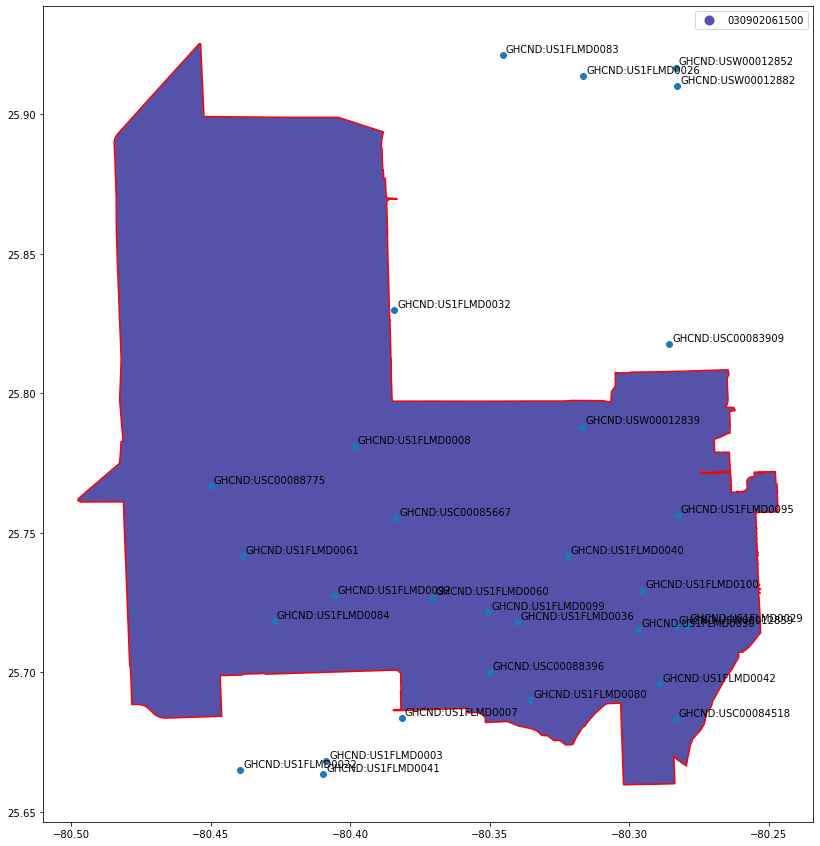

In [43]:
#from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(15, 15))
hucs_gdf.plot(ax=ax, alpha=0.7, cmap="plasma",cax=f'huc{len(huc)}',column=f'huc{len(huc)}',legend=True)
basin_gdf.boundary.plot(ax=ax,color='red')
rain_gage_gdf.plot(ax=ax)
for x, y, label in zip(rain_gage_gdf.geometry.x, rain_gage_gdf.geometry.y, rain_gage_gdf.STATION_ID):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    # ax.add_artist(ScaleBar(1))

In [45]:
#user selected
rain_site = 'US1FLMD0042'
#write gage # to txt file for later notebooks
with open(home/'Inputs'/'rain_gage.txt','w') as tfile:
    tfile.write(rain_site)